In [1]:
import networkx as nx
import osmnx as ox

In [2]:
# Dodaje odpowiednie tagi do filtrów - w osmnx jest używany Overpas QL, można tworzyć też customowe filtry
ox.settings.useful_tags_way+=['cycleway', 'surface']
ox.settings.useful_tags_way

['bridge',
 'tunnel',
 'oneway',
 'lanes',
 'ref',
 'name',
 'highway',
 'maxspeed',
 'service',
 'access',
 'area',
 'landuse',
 'width',
 'est_width',
 'junction',
 'cycleway',
 'surface']

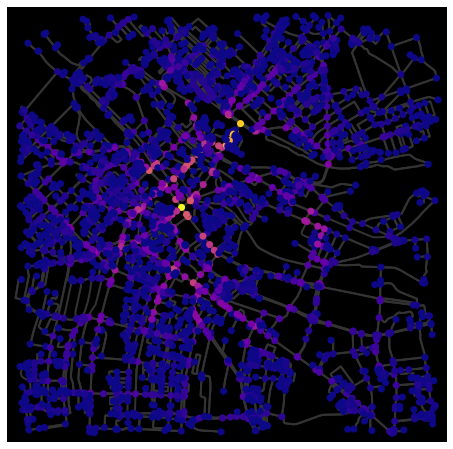

In [47]:
import networkx as nx
import osmnx as ox
useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name',
                    'highway', 'maxspeed', 'service', 'access', 'area',
                    'landuse', 'width', 'est_width', 'junction', 'surface']
# ox.utils.config(useful_tags_path=useful_tags_path) # deprecatedd

# # useful_tags = ox.settings.useful_tags_path + ['cycleway']
# ox.useful_tags_way = ox.settings.useful_tags_way + ['cycleway', 'surface']
# ox.settings.useful_tags_path = ox.settings.useful_tags_way + ['bicycle', 'surface']

# download street network data from OSM and construct a MultiDiGraph model
# 50.291100737108025, 18.680043199195698 - RMS
G = ox.graph.graph_from_point((50.291100737108025, 18.680043199195698), dist=2000, network_type="bike")


# impute edge (driving) speeds and calculate edge travel times
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)
# you can convert MultiDiGraph to/from GeoPandas GeoDataFrames

# gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
# G = ox.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

# convert MultiDiGraph to DiGraph to use nx.betweenness_centrality function
# choose between parallel edges by minimizing travel_time attribute value
D = ox.utils_graph.get_digraph(G, weight="length")

# calculate node betweenness centrality, weighted by travel time
bc = nx.betweenness_centrality(D, weight="length", normalized=True)
nx.set_node_attributes(G, values=bc, name="bc")

# plot the graph, coloring nodes by betweenness centrality
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot.plot_graph(
    G, bgcolor="k", node_color=nc, node_size=50, edge_linewidth=2, edge_color="#333333"
)

# # save graph as a geopackage or graphml file
# ox.io.save_graph_geopackage(G, filepath="./graph.gpkg")
# ox.io.save_graphml(G, filepath="./graph.graphml")

In [48]:
# Tworzy projekcje z CRS do normalnego UTM - TODO: trzeba doczytać
G = ox.project_graph(G, to_latlong=True)

In [49]:
# Lista rodzajów nawierzchni w grafie
edges = ox.graph_to_gdfs(G, nodes=False)
edges["surface"].explode().unique()

array([nan, 'paved', 'asphalt', 'cobblestone', 'ground', 'paving_stones',
       'gravel', 'sett', 'concrete', 'earth', 'compacted', 'dirt',
       'unpaved', 'wood', 'pebblestone', 'fine_gravel', 'grass',
       'grass_paver', 'concrete:plates', 'unhewn_cobblestone'],
      dtype=object)

In [50]:
edges.head()

osmid      name      highway  oneway  \
u        v         key                                                      
17503166 17503174  0               8128378  Sportowa  residential   False   
         332455135 0               8128379  Sportowa  residential   False   
         17503386  0    [8128379, 8128381]  Sportowa  residential   False   
17503174 17503166  0               8128378  Sportowa  residential   False   
         17503386  0             299971362  Sportowa  residential   False   

                             reversed   length  speed_kph  travel_time  \
u        v         key                                                   
17503166 17503174  0            False  102.377       32.2         11.4   
         332455135 0             True   13.187       32.2          1.5   
         17503386  0    [False, True]  201.732       32.2         22.6   
17503174 17503166  0             True  102.377       32.2         11.4   
         17503386  0            False  126.926       32.2         14.2   

                                                                 geometry  \
u        v         key                                                      
17503166 17503174  0    LINESTRING (18.70212 50.29181, 18.70083 50.29140)   
         332455135 0    LINESTRING (18.70212 50.29181, 18.70205 50.29192)   
         17503386  0    LINESTRING (18.70212 50.29181, 18.70236 50.291...   
17503174 17503166  0    LINESTRING (18.70083 50.29140, 18.70212 50.29181)   
         17503386  0    LINESTRING (18.70083 50.29140, 18.70097 50.291...   

                       lanes surface maxspeed access service  ref tunnel  \
u        v         key                                                     
17503166 17503174  0     NaN     NaN      NaN    NaN     NaN  NaN    NaN   
         332455135 0     NaN     NaN      NaN    NaN     NaN  NaN    NaN   
         17503386  0     NaN     NaN      NaN    NaN     NaN  NaN    NaN   
17503174 17503166  0     NaN     NaN      NaN    NaN     NaN  NaN    NaN   
         17503386  0     NaN     NaN      NaN    NaN     NaN  NaN    NaN   

                       junction cycleway bridge width  
u        v         key                                 
17503166 17503174  0        NaN      NaN    NaN   NaN  
         332455135 0        NaN      NaN    NaN   NaN  
         17503386  0        NaN      NaN    NaN   NaN  
17503174 17503166  0        NaN      NaN    NaN   NaN  
         17503386  0        NaN      NaN    NaN   NaN

In [51]:
import matplotlib.pyplot as plt

# Tworzenie kolorowania dla krawędzi o różnych nawierzchniach
surface_mapping = {v: k for k, v in enumerate(edges["surface"].explode().unique())}
cmap_type = plt.get_cmap('Set3')

edge_coloring = []
for u, v, att in G.edges(data=True):
    if  "surface" in att:
        if isinstance(att["surface"], list):
            surf = att["surface"][0]
            r,g,b,a = cmap_type(surface_mapping[surf])
        else:
            surf = att["surface"]
            r,g,b,a = cmap_type(surface_mapping[surf])
    else:
        r,g,b,a = cmap_type(-1)
        # (u, v, 0) -> key
    edge_coloring.append([r, g, b, 0.3*a]) # 0.3 żeby nie były tak jasne

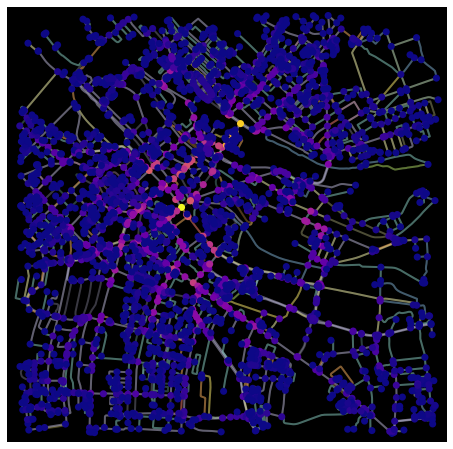

In [52]:
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot.plot_graph(
    G, bgcolor="k", node_color=nc, node_size=50, edge_linewidth=2, edge_color=edge_coloring
)

# Dodanie wag związanych z rodzajem trasy

In [53]:
# Dodanie funckje wagi, która zwraca daną wartości zależnie od tego, czy droga jest asfaltowa lub inna
# Na razie roboczo tylko tak dla testów - będzie można się tym pobawić i przede wszystkim uzależnić od preferencji użytkownika. Również wziąć różne typy tras pod uwagę
# Jeśli chodzi o wartości liczbowe to +/-, żeby jakoś działało
def weight_func(u, v, d):
    key = 0 # TODO: zobaczyc czy key moze byc inny niz 0
    if "surface" in d.keys():
        if d[key]["surface"]=="asphalt":
            return 500
    return 0

def weight_func_back(u, v, d):
    key = 0 # TODO: zobaczyc czy key moze byc inny niz 0
    # if "visited" in d.keys():
    if d[key]["visited"]==True:
        return weight_func_dist(u, v, d) + float('inf')
    return weight_func_dist(u, v, d)

def weight_func_dist(u, v, d):
    key = 0 # TODO: zobaczyc czy key moze byc inny niz 0
    # if "visited" in d.keys():
    return weight_func(u, v, d) + d[key]["length"]

In [54]:
# Funkcja dystansu, tutaj z uzwględnieniem krzywizny ziemi
def dist(a, b):
    re = ox.distance.great_circle(lat1=G.nodes[a]['y'],
                             lon1=G.nodes[a]['x'],
                             lat2=G.nodes[b]['y'],
                             lon2=G.nodes[b]['x']
                             )
    return re

In [55]:
import math
def dist_manhattan(a, b):
    lat1=G.nodes[a]['y']
    lon1=G.nodes[a]['x']
    lat2=G.nodes[b]['y']
    lon2=G.nodes[b]['x']
    lat_ratio = lambda x: x*111574
    lon_ratio = lambda x: math.cos(math.radians(x))*111320
    re = (lat_ratio(abs(lat2-lat1)) + lon_ratio(abs(lon2-lon1)))
    return re

### Poniżej zaprezentowana jest różnica w działaniu A* z wagami i wybraną heurystyką, a bez niech (waga jako długość krawędzi) 

In [56]:
# Losowy punkt startowy (tutaj kochany RMS) 50.291100737108025, 18.680043199195698
a = ox.nearest_nodes(G, Y=50.291100737108025, X=18.680043199195698)
# Drugi jakiś randomowy 50.29407909135578, 18.666791202052075
b = ox.nearest_nodes(G, Y=50.29407909135578, X=18.666791202052075)

In [57]:
# Dystanse
for id, value in G.nodes(data=True):
    print(dist(a,id))

1579.7485057510685
1485.6045387340323
1575.6370655161331
1546.8581343179478
1412.6774420876989
1536.7471851109303
1620.8651188960334
1830.6060074562413
1646.3886543144856
1650.056453851128
1655.8274637979118
1793.5686414300233
1603.796978115082
1314.417133734662
1319.0475195137833
1127.9520258519276
1310.7941897215408
1356.8036225817764
1136.1897535385215
1018.4480947228765
923.4062881895104
954.7832296441784
895.547194973102
1330.0707890678302
1323.877542705894
1339.0441086786875
1402.7801423560488
1467.3700538812238
1522.337251321084
1493.7298109808628
1576.345697997336
1605.6854860448311
1564.0443554916724
1681.9929601222993
1576.9432119177711
1710.5783502995998
1673.9529110041165
1730.9863823885478
1167.3338779205799
1176.8114801857544
1154.0771638089016
1180.8907183161878
1350.9796810529745
1345.6382542021038
1429.523311040232
1666.9102659904274
1240.1389266452918
1232.4880684797101
1128.3262609941314
1255.773154205902
1263.668297066971
1274.409316440581
1497.1593530786195
1445.08

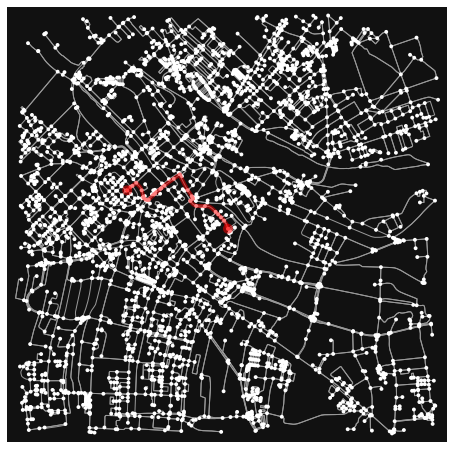

In [58]:
path = nx.astar_path(G, a, b, heuristic=dist ,weight=weight_func)
fig, ax = ox.plot_graph_route(G, path)

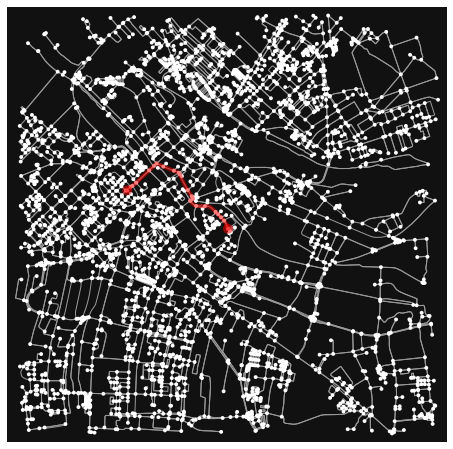

In [59]:
path = nx.astar_path(G, a, b, heuristic=dist, weight="length")
fig, ax = ox.plot_graph_route(G, path)

# Algorytm

In [16]:
# def makeRoute(start, distance, dist_func = dist):
#     # Set visited to False
#     visited_mapping = {(u, v, 0) : False for u,v,d in G.edges(data=True)}
#     nx.set_edge_attributes(G, visited_mapping, "visited")
#     # Going out
#     err = 10
#     path = []
#     part = distance/5
#     total_distance = 0
#     a = start
#     b = start
#     for id, vals in G.nodes(data=True):
#         d = dist_func(a,id)
#         if part-err<d<part+err:
#             b = id
#             break
#     path+=nx.astar_path(G, a, b, heuristic=dist_func, weight=weight_func_dist)

#     total_distance = nx.path_weight(G, path, 'length')
#     print(total_distance)
#     while(total_distance<distance/2):
#         a = b
#         for id, vals in G.nodes(data=True):
#             d = dist_func(a,id)
#             d_from_start = dist_func(start,id)
#             if part-err<d<part+err and part<d_from_start:
#                 b = id
#                 break
#         path+=nx.astar_path(G, a, b, heuristic=dist_func ,weight=weight_func_dist)[1:]
#         total_distance = nx.path_weight(G, path, 'length')
#         print(total_distance)

#     a = b
#     # Oh no! go back
#     for u, v in zip(enumerate(path), enumerate(path[1:])): # xD
#         # TODO: clean up this crap
#         u = u[1]
#         v = v[1]
#         G.edges[(u,v,0)]["visited"]=True
#     path+=nx.astar_path(G, a, start, heuristic=dist_func ,weight=weight_func_back)[1:]

#     print(path)
#     print(f"Dystans: {nx.path_weight(G, path, 'length')}m")
#     return path

In [17]:
# import numpy as np
# def makeRoute(start, distance, error = 10, divisions = 5, dist_func = dist):
    
#     # Set visited to False
#     visited_mapping = {(u, v, 0) : False for u,v,d in G.edges(data=True)}
#     nx.set_edge_attributes(G, visited_mapping, "visited")

#     ### Going out ###
#     path = []
#     part = distance/divisions # distance for the smaller parts of the route
#     total_distance = 0

#     # Set current start and finish
#     a = start
#     b = start
#     possible_b_points = []
#     for id, vals in G.nodes(data=True):
#         d = dist_func(a, id) # Distance between 'a' and inspected node
#         if part-error<d<part+error:
#             possible_b_points.append(id)
    
#     # Find closest to partial distance
#     best_partial_distance = 0.0
#     best_b = b
#     for i, iter_b in enumerate(possible_b_points):
#         partial_path = nx.astar_path(G, a, iter_b, heuristic=dist_func, weight=weight_func_dist)
#         partial_distance = nx.path_weight(G, partial_path, 'length')
#         if np.abs(partial_distance - part) <  np.abs(best_partial_distance - part):
#             best_partial_distance = partial_distance
#             best_b = iter_b
#     b = best_b
#     # b = np.random.choice(possible_b_points, size=1)[0] # TODO: clean up, so the value is unpacked from an array (workaround with '[0]')
#     path+=nx.astar_path(G, a, b, heuristic=dist_func, weight=weight_func_dist)

#     total_distance = nx.path_weight(G, path, 'length')
#     print(total_distance)
#     possible_b_points = []
#     best_partial_distance = 0.0
#     best_b = b
#     while(total_distance<distance/2):
#         a = b
#         for id, vals in G.nodes(data=True):
#             d = dist_func(a, id)
#             d_from_start = dist_func(start, id)
#             if part-error<d<part+error and part<d_from_start:
#                 possible_b_points.append(id)
                
#         # Find closest to partial distance
#         best_partial_distance = 0.0
#         best_b = b
#         for i, iter_b in enumerate(possible_b_points):
#             partial_path = nx.astar_path(G, a, iter_b, heuristic=dist_func, weight=weight_func_dist)
#             partial_distance = nx.path_weight(G, partial_path, 'length')
#             if np.abs(partial_distance - part) <  np.abs(best_partial_distance - part):
#                 best_partial_distance = partial_distance
#                 best_b = iter_b
#         b = best_b
#         path+=nx.astar_path(G, a, b, heuristic=dist_func ,weight=weight_func_dist)[1:]
#         total_distance = nx.path_weight(G, path, 'length')
#         print(total_distance)

#     a = b
#     # Oh no! go back
#     for u, v in zip(enumerate(path), enumerate(path[1:])): # xD
#         # TODO: clean up this crap
#         u = u[1]
#         v = v[1]
#         G.edges[(u,v,0)]["visited"]=True
#     path+=nx.astar_path(G, a, start, heuristic=dist_func ,weight=weight_func_back)[1:]

#     print(path)
#     print(f"Dystans: {nx.path_weight(G, path, 'length')}m")
#     return path

In [18]:
# import numpy as np
# def makeRoute(start, distance, error = 10, divisions = 5, dist_func = dist):
    
#     # Set visited to False
#     visited_mapping = {(u, v, 0) : False for u,v,d in G.edges(data=True)}
#     nx.set_edge_attributes(G, visited_mapping, "visited")

#     ### Going out ###
#     path = []
#     part = distance/divisions # distance for the smaller parts of the route
#     total_distance = 0

#     # Set current start and finish
#     a = start
#     b = start
#     possible_b_points = []
#     for id, vals in G.nodes(data=True):
#         d = dist_func(a, id) # Distance between 'a' and inspected node
#         if part-error<d<part+error:
#             possible_b_points.append(id)
    
#     # Find closest to partial distance
#     best_partial_distance = 0.0
#     best_b = b
#     for i, iter_b in enumerate(possible_b_points):
#         partial_path = nx.astar_path(G, a, iter_b, heuristic=dist_func, weight=weight_func_dist)
#         partial_distance = nx.path_weight(G, partial_path, 'length')
#         if np.abs(partial_distance - part) <  np.abs(best_partial_distance - part):
#             best_partial_distance = partial_distance
#             best_b = iter_b
#     b = best_b
#     # b = np.random.choice(possible_b_points, size=1)[0] # TODO: clean up, so the value is unpacked from an array (workaround with '[0]')
#     path+=nx.astar_path(G, a, b, heuristic=dist_func, weight=weight_func_dist)

#     total_distance = nx.path_weight(G, path, 'length')
#     print(total_distance)
#     possible_b_points = []
#     best_partial_distance = 0.0
#     best_b = b
#     while(total_distance<distance/2):
#         a = b
#         for id, vals in G.nodes(data=True):
#             d = dist_func(a, id)
#             d_from_start = dist_func(start, id)
#             if part-error<d<part+error and part<d_from_start:
#                 possible_b_points.append(id)
                
#         # Find closest to partial distance
#         best_partial_distance = 0.0
#         best_b = b
#         for i, iter_b in enumerate(possible_b_points):
#             partial_path = nx.astar_path(G, a, iter_b, heuristic=dist_func, weight=weight_func_dist)
#             partial_distance = nx.path_weight(G, partial_path, 'length')
#             if np.abs(partial_distance - part) <  np.abs(best_partial_distance - part):
#                 best_partial_distance = partial_distance
#                 best_b = iter_b
#         b = best_b
#         path+=nx.astar_path(G, a, b, heuristic=dist_func ,weight=weight_func_dist)[1:]
#         total_distance = nx.path_weight(G, path, 'length')
#         print(total_distance)

#     a = b
#     # Oh no! go back
#     for u, v in zip(enumerate(path), enumerate(path[1:])): # xD
#         # TODO: clean up this crap
#         u = u[1]
#         v = v[1]
#         G.edges[(u,v,0)]["visited"]=True
#     path+=nx.astar_path(G, a, start, heuristic=dist_func ,weight=weight_func_back)[1:]

#     print(path)
#     print(f"Dystans: {nx.path_weight(G, path, 'length')}m")
#     return path

In [19]:
# import numpy as np
# def makeRoute(start, distance, error = 10, divisions = 5, dist_func = dist):
#     ### init varaibles ###
#     path = [start]
#     part = distance/divisions # distance for the smaller parts of the route
#     part_previous = part
#     total_distance = 0

#     # Set visited to False
#     visited_mapping = {(u, v, 0) : False for u, v, d in G.edges(data=True)}
#     nx.set_edge_attributes(G, visited_mapping, "visited")

#    # Set current start and finish
#     a = start
#     b = start
#     previous = start

#     ### "Going for a little walk, brb" part ###
    
#     for i in range(divisions):
#         try:
#             b = findPart(a, previous, part, part_previous, error, dist_func)
#             part_path = nx.astar_path(G, a, b, heuristic=dist_func, weight=weight_func_dist)
#         except: # Re-run the algorithm
#             return makeRoute(start, distance, error, divisions, dist_func)
#         part_distance = nx.path_weight(G, part_path, 'length')

#         # # Update state of nodes:
#         # previous = a
#         # a = b

#         # Check path back from the found part:
#         back_path = nx.astar_path(G, b, start, heuristic=dist_func, weight=weight_func_back)
#         back_distance = nx.path_weight(G, back_path, 'length')

#         # See if need to go back and what approach is better:

#         if total_distance+part_distance+back_distance > distance+part: # If found solution is too long
#             back_path_previous = nx.astar_path(G, a, start, heuristic=dist_func, weight=weight_func_back)
#             back_distance_previous = nx.path_weight(G, back_path_previous, 'length')
#             if total_distance+back_distance_previous > distance-part: # If previous solution is long enough
#                 path += back_path_previous[1:]
#                 total_distance = nx.path_weight(G, path, 'length')
#             else:  # if not, rerun 'finding part' with smaller range
#                 i -= 1
#                 part_previous /= 2
#                 continue
#         elif total_distance+part_distance+back_distance > distance-part: # if found solution is long enough, go back
#             path += part_path[1:]
#             path += back_path[1:]
#             total_distance = nx.path_weight(G, path, 'length')
#             break
#         # Otherwise, continue walk

#         # Update state of nodes:
#         previous = a
#         a = b



#         # # # total_distance = nx.path_weight(G, path+part_path, 'length')
#         # # # print(f"{i}: {total_distance}")

#         # # # # Update state of nodes:
#         # # # previous = a
#         # # # a = b

#         # # # Check if need to go back
#         # # back_path = nx.astar_path(G, a, start, heuristic=dist_func, weight=weight_func_back)
#         # # back_distance = nx.path_weight(G, back_path, 'length')
#         # if distance+part > back_distance+total_distance > distance-part:
#         #     break
#     # path+= back_path[1:] # Remove duplicate node
#     # total_distance = nx.path_weight(G, path, 'length')
#     print(total_distance)
#     return path
    

    
# def findPart(start, previous, distance, distance_previous, error, dist_func = dist):
#     possible_b_points = []
#     a = start
#     for id, vals in G.nodes(data=True):
#         d = dist_func(a, id) # Distance between 'a' node and inspected node
#         d_prev = dist_func(previous, id) # Distance between 'previous' node and inspected node
#         if distance-error < d < distance+error and distance_previous-error < d_prev < distance_previous+error:
#             possible_b_points.append(id)
#     if len(possible_b_points) == 0:
#         return findPart(start, previous, distance, error*2, dist_func) # double the allowed error
#     b = np.random.choice(possible_b_points, size=1)[0]  # Pick point at random
#     return b

In [101]:
import numpy as np
def makeRoute(start, distance, error = 10, divisions = 4, dist_func = dist):
    ### init varaibles ###
    path = [start]
    part = distance/divisions # distance for the smaller parts of the route
    part_previous = part
    total_distance = 0
    acceptable_attemps = 0
    i = 0

    # Set visited to False
    visited_mapping = {(u, v, 0) : False for u, v, d in G.edges(data=True)}
    nx.set_edge_attributes(G, visited_mapping, "visited")

   # Set current start and finish
    a = start
    b = start
    previous = start

    ### "Going for a little walk, brb" part ###
    
    while acceptable_attemps < 10:

        try: # Try to find destination point - if not accessible, try again
            b = findPart(a, previous, part, part_previous, error, dist_func)
            part_path = nx.astar_path(G, a, b, heuristic=dist_func, weight=weight_func_dist)
            part_distance = nx.path_weight(G, part_path, 'length')
        except: # Re-run the iteration
            continue

        # Check path back from the found 'b' node:
        try:
            back_path = nx.astar_path(G, b, start, heuristic=dist_func, weight=weight_func_back)
            back_distance = nx.path_weight(G, back_path, 'length')
        except:
            continue

        # See if need to go back and what approach is better:
        if total_distance+part_distance+back_distance > distance*1.05:
            try:
                back_path_previous = nx.astar_path(G, a, start, heuristic=dist_func, weight=weight_func_back)
                back_distance_previous = nx.path_weight(G, back_path_previous, 'length')
            except:
                continue
            if total_distance+back_distance_previous > distance*0.95: # If previous solution is long enough
                path += back_path_previous[1:]
                print("exit a")
                total_distance = nx.path_weight(G, path, 'length')
                print(total_distance)
                return path
            else: # If it is not, try with a smaller part
                part /= 2
                acceptable_attemps +=1
                continue
        elif total_distance+part_distance+back_distance > distance*0.95: # if found solution is long enough, go back
            print("exit b")
            break
        # Otherwise, continue walk
        
        # Update state of nodes, path and algorithm:
        if i >= divisions:
            break
        part_previous = part
        i+=1
        path += part_path[1:]
        total_distance = nx.path_weight(G, path, 'length')
        previous = a
        a = b

    ### end of loop ###
    # print(path)
    path += part_path[1:]
    path += back_path[1:]
    # print(part_path)
    # print(back_path)
    print(i, acceptable_attemps)
    total_distance = nx.path_weight(G, path, 'length')
    print(total_distance)
    return path
    
def findPart(start, previous, distance, distance_previous, error, dist_func = dist):
    possible_b_points = []
    a = start
    for id, vals in G.nodes(data=True):
        d = dist_func(a, id) # Distance between 'a' node and inspected node
        d_prev = dist_func(previous, id) # Distance between 'previous' node and inspected node
        if distance-error < d < distance+error and distance_previous-error < d_prev < distance_previous+error:
            possible_b_points.append(id)
    if len(possible_b_points) == 0:
        return findPart(start, previous, distance, distance_previous, error*2, dist_func) # double the allowed error
    b = np.random.choice(possible_b_points, size=1)[0]  # Pick point at random
    return b

exit b
1 0
7768.550999999998


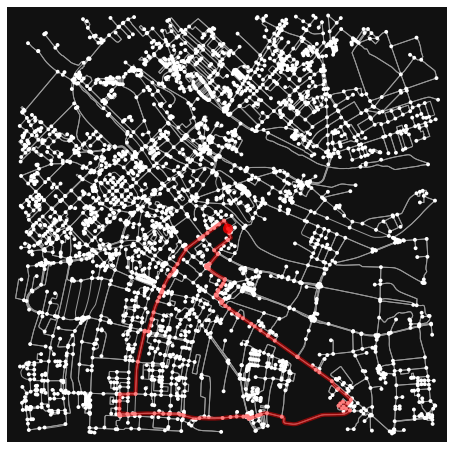

In [108]:
path = makeRoute(a, 8000)
fig, ax = ox.plot_graph_route(G, path)
# path = makeRoute(a, 2700)
# fig, ax = ox.plot_graph_route(G, path)
# path = makeRoute(a, 3200)
# fig, ax = ox.plot_graph_route(G, path)

In [111]:
path_cords = []
for el in path:
    path_cords.append([G.nodes[el]['y'], G.nodes[el]['x']])

In [112]:
path_cords

[[50.2907735, 18.6799432],
 [50.2903914, 18.6801092],
 [50.2898182, 18.6799469],
 [50.2898001, 18.6799094],
 [50.2889292, 18.67809],
 [50.2885864, 18.6785844],
 [50.2877408, 18.6774878],
 [50.2876493, 18.6771302],
 [50.2876347, 18.6770715],
 [50.2875212, 18.6769883],
 [50.2874967, 18.6769982],
 [50.2874241, 18.6771465],
 [50.2874253, 18.6771957],
 [50.287338, 18.6773684],
 [50.2864513, 18.6795515],
 [50.2863842, 18.6795083],
 [50.2860524, 18.6792801],
 [50.2858387, 18.679022],
 [50.2854688, 18.6786368],
 [50.2854358, 18.6786022],
 [50.2851216, 18.6782931],
 [50.2850512, 18.6784611],
 [50.2845453, 18.6792075],
 [50.2844015, 18.679056],
 [50.2841611, 18.6795815],
 [50.284139, 18.679633],
 [50.2839248, 18.6801077],
 [50.2834505, 18.6811577],
 [50.2833378, 18.6814079],
 [50.2830926, 18.6819598],
 [50.2826086, 18.683075],
 [50.2824029, 18.6835273],
 [50.2820442, 18.6843169],
 [50.2815928, 18.6853052],
 [50.2811696, 18.686232],
 [50.2798021, 18.6892264],
 [50.27976, 18.6893198],
 [50.2786737

In [110]:
G.nodes[path[0]]['y']
G.nodes[path[0]]['x']

18.6799432

### Na innych funkcjach wag i kosztu

In [20]:
def dist2(a, b):
    re = ox.distance.euclidean(y1=G.nodes[a]['y'],
                             x1=G.nodes[a]['x'],
                             y2=G.nodes[b]['y'],
                             x2=G.nodes[b]['x']
                             )
    return re

In [21]:
def weight_func(u, v, d):
    key = 0
    if "surface" in d.keys():
        if d[key]["surface"]=="asphalt":
    #         return 100
    # return 50

    # Euclidean zwraca w innych jednostkach niż ten wielki krąg
                return 0.001
    return 0

In [22]:
# Inna jednostka
for id, value in G.nodes(data=True):
    print(dist2(a,id))

0.00881769357711891
0.008997208467072727
0.008678865668396192
0.007982255200756601
0.008040893632548842
0.007775032116334073
0.008731918156395232
0.007361308579322102
0.007021245875911659
0.008388637408420349
0.013732033629802737
0.01336436400768929
0.01355682283022117
0.010302337876908168
0.009907885096223422
0.010374424788394013
0.010412379670851681
0.010297261640844265
0.012125538147644577
0.011895088493155005
0.011233119791492047
0.010055594039637813
0.009218640771828367
0.010671055683953367
0.008945292521209925
0.012776261991679968
0.012668708727412804
0.006493313331419219
0.005603198758746449
0.007450120469496735
0.005697247708324015
0.005372539031968646
0.005000519045060783
0.005295238431835126
0.005604764865720751
0.004919864097715543
0.0065671415981362205
0.007094504746636445
0.005393231461752441
0.006366801196833579
0.00449600748442627
0.004450176689751867
0.004410792729204025
0.0043634861349602285
0.004293280248250816
0.004339912640823168
0.004193490170489056
0.0116873525304

In [23]:
def makeRoute(start, distance, dist_func = dist):
    # Going out
    err = 0.001
    path = []
    part = distance/4
    a = start
    b = start
    for id, vals in G.nodes(data=True):
        d = dist_func(a,id)
        if part-err<d<part+err:
            b = id
            break
    path+=nx.astar_path(G, a, b, heuristic=dist_func ,weight=weight_func)

    a = b
    for id, vals in G.nodes(data=True):
        d = dist_func(a,id)
        d_from_start = dist_func(start,id)
        if part-err<d<part+err and part<d_from_start<part*2:
            b = id
            break
    path+=nx.astar_path(G, a, b, heuristic=dist_func ,weight=weight_func)[1:]

    a = b
    # Oh no! go back
    path+=nx.astar_path(G, a, start, heuristic=dist_func ,weight=weight_func)[1:]

    print(path)
    return path

[264864144, 264864141, 10875759356, 10875759352, 262832464, 2480216712, 2480216725, 900922307, 29428610, 2448195758, 3525829441, 29428609, 2448166834, 2496833019, 29015377, 976244273, 29428601, 29428599, 2390545800, 29428598, 2708844022, 628824724, 628824731, 29428595, 628824731, 628824724, 2708844022, 29428598, 2708844338, 29017191, 29015376, 634439571, 2449926350, 2448167002, 2449926402, 31729684, 2449926445, 11148966242, 2448195950, 29018671, 2449926588, 29402527, 1803084601, 3561365741, 29018448, 1952422062, 1969556124, 29103943, 262830039, 3907002778, 29104023, 5325836463, 1947396931, 1947295075, 4695741280, 29403439, 1690389849, 1690389850, 288601683, 1690389850, 1690389849, 8794529937, 8794529930, 610239434, 1361900011, 7865036436, 1361900085, 3878749030, 10572932287, 6598747400, 10858347611, 1021168198, 1021168065, 2040437211, 610299260, 1952219115, 610299258, 610299257, 262830042, 262639795, 1969556143, 1969556134, 1969556117, 3850414598, 3850414588, 1952422062, 29018448, 2648

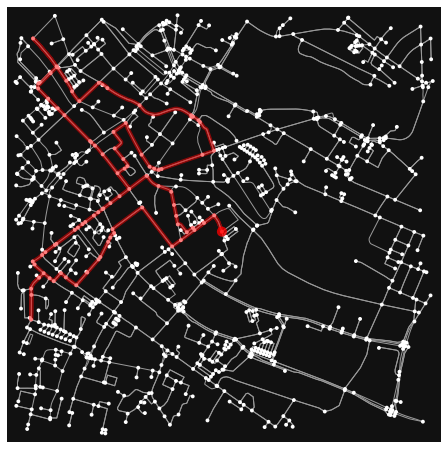

In [24]:
path = makeRoute(a, 0.05, dist_func=dist2)
fig, ax = ox.plot_graph_route(G, path)

# Other bullshit (moze się potem przydać do prezentacji idk)

In [25]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.nearest_nodes(G,x[0],y[0])
G = ox.project_graph(G)

In [26]:
# place = 'Berkeley, CA, USA'
# network_type = 'walk'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [27]:
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [28]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

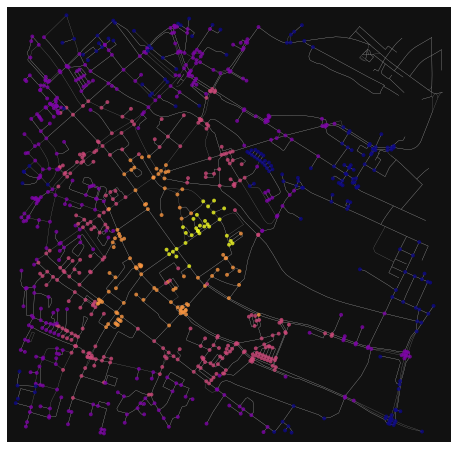

In [29]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999')